In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve,auc
import seaborn as sns
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


## 1. Data preprocessing

- The merged dataset containers data leakage features which are features that wouldnt be available in real-world prediction such as `max_delay`, `avg_delay`, `num_bad_months`, `months_total`. The target variable `label`, `id` and `amt_income_total` (to use the log transformed income) are also dropped. The target variable `label` is converted to integer for classification
- Applied one-hot encoding to categorical variables 
- Applied train-test split and SMOTE

In [2]:
df = pd.read_csv("../data/clean_merged.csv")


In [3]:
y = df['label'].astype('int')
leaky_features = ['max_delay', 'avg_delay', 'num_bad_months', 'months_total']
X = df.drop(columns=['label', 'id', 'amt_income_total'] + leaky_features)



In [4]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True) #one-hot encoding
else:
    X_encoded = X

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
X_train.head()

,code_gender,flag_own_car,flag_own_realty,cnt_children,flag_mobil,flag_work_phone,flag_phone,flag_email,cnt_fam_members,age,...,occupation_type_Low-skill Laborers,occupation_type_Managers,occupation_type_Medicine staff,occupation_type_Private service staff,occupation_type_Realty agents,occupation_type_Sales staff,occupation_type_Secretaries,occupation_type_Security staff,occupation_type_Unknown,occupation_type_Waiters/barmen staff
5155,0,0,1,0,1,0,1,0,2,64,...,False,False,False,False,False,False,False,False,True,False
229,0,1,1,0,1,0,1,1,2,28,...,False,False,False,False,False,False,False,False,False,False
17709,1,1,1,0,1,0,1,1,2,44,...,False,True,False,False,False,False,False,False,False,False
10802,0,0,1,1,1,0,1,0,2,41,...,False,False,False,True,False,False,False,False,False,False
15990,1,0,1,0,1,0,1,0,2,46,...,False,False,False,False,False,False,False,False,False,False


In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29165 entries, 5155 to 18335
Data columns (total 48 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   code_gender                                        29165 non-null  int64  
 1   flag_own_car                                       29165 non-null  int64  
 2   flag_own_realty                                    29165 non-null  int64  
 3   cnt_children                                       29165 non-null  int64  
 4   flag_mobil                                         29165 non-null  int64  
 5   flag_work_phone                                    29165 non-null  int64  
 6   flag_phone                                         29165 non-null  int64  
 7   flag_email                                         29165 non-null  int64  
 8   cnt_fam_members                                    29165 non-null  int64  
 9   age     

In [7]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# apply SMOTE 
smote = SMOTE(random_state=42)
X_balance, y_balance = smote.fit_resample(X_train, y_train)
print(f"Class distribution of y after SMOTE: {Counter(y_balance)}")
print(f"Class distribution of y without SMOTE: {Counter(y_test)}")

Class distribution of y after SMOTE: Counter({0: 28672, 1: 28672})
Class distribution of y without SMOTE: Counter({0: 7169, 1: 123})


## 2. Random Forest Model (Baseline)

### 2.1 Baseline model

Random Forest is an ensemble learning method based on building multiple decision trees during training and combining their predictions by majority vote for classification. 

This makes the model:
- Generalise better and avoid overfitting
- Handle non-linear relationships
- Automatically estimate feature importance

The first model is a baseline model that is simple and unoptimised version that uses the original imbalanced data with default Random Forest hyperparameters to provide a reference point.

In [8]:
# Train Random forest classifier
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_model.fit(X_train, y_train)

# Make predictions on test set
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))  # y_test loaded as true test targets
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9809380142622052

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      7169
           1       0.35      0.15      0.21       123

    accuracy                           0.98      7292
   macro avg       0.67      0.57      0.60      7292
weighted avg       0.97      0.98      0.98      7292


Confusion Matrix:
 [[7135   34]
 [ 105   18]]


### 2.2 Baseline Model (using only the top 10 most important features)

Rationale for reducing to top 10 most important features:
- Interpretability 
- Eliminates noisy or irrelevant features that might affect accuracy of model
- Reduce likelihood of model learning random patterns 
- Fewer inputs = Increase training efficiency

In [9]:
# Get feature importances and feature names
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Make a DataFrame for easy sorting/viewing
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feat_imp_df

,feature,importance
9,age,0.178045
12,amt_income_log,0.170976
11,years_employed,0.167790
8,cnt_fam_members,0.042958
1,flag_own_car,0.029785
6,flag_phone,0.029443
2,flag_own_realty,0.029099
3,cnt_children,0.027607
16,name_income_type_Working,0.025044
0,code_gender,0.024715


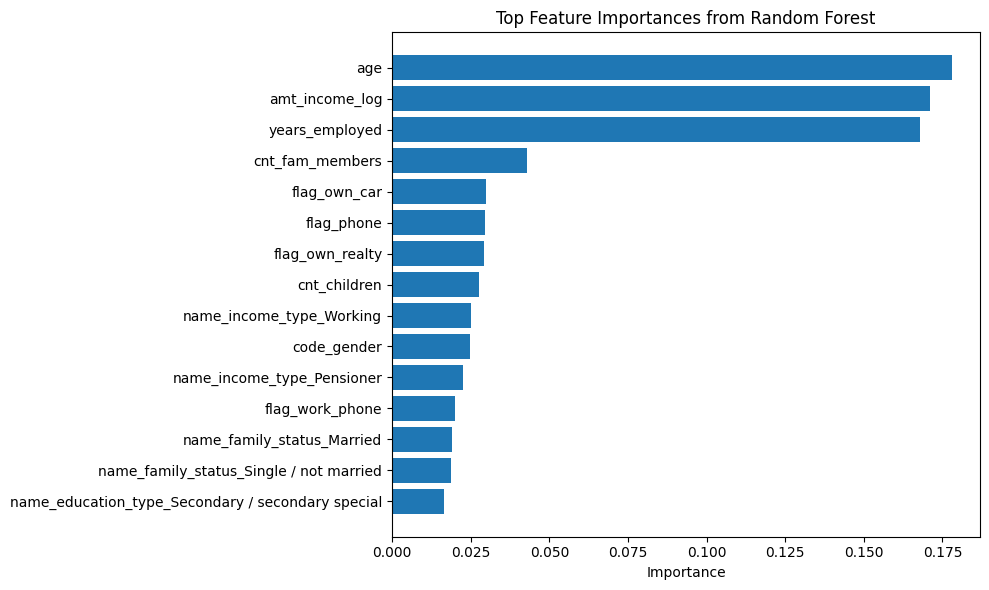

In [10]:
# Plot top N features (e.g. top 15)
N = 15
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['feature'][:N][::-1], feat_imp_df['importance'][:N][::-1])
plt.xlabel('Importance')
plt.title('Top Feature Importances from Random Forest')
plt.tight_layout()
plt.show()

In [11]:
print(feat_imp_df.head(10))  # Show top 10 important features

                     feature  importance
9                        age    0.178045
12            amt_income_log    0.170976
11            years_employed    0.167790
8            cnt_fam_members    0.042958
1               flag_own_car    0.029785
6                 flag_phone    0.029443
2            flag_own_realty    0.029099
3               cnt_children    0.027607
16  name_income_type_Working    0.025044
0                code_gender    0.024715


In [12]:
# reduce train and test to selected features

N = 10
top_features = feat_imp_df['feature'].iloc[:N].tolist()
top_features

X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

In [13]:
rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_reduced.fit(X_train_reduced, y_train)

y_pred_reduced = rf_reduced.predict(X_test_reduced)

print("Accuracy with reduced features:", accuracy_score(y_test, y_pred_reduced))

print("\nClassification Report:\n", classification_report(y_test, y_pred_reduced))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_reduced))

Accuracy with reduced features: 0.9810751508502469

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      7169
           1       0.36      0.16      0.22       123

    accuracy                           0.98      7292
   macro avg       0.67      0.58      0.61      7292
weighted avg       0.98      0.98      0.98      7292


Confusion Matrix:
 [[7134   35]
 [ 103   20]]


After feature reduction:
- Accuracy improved slightly: 0.9809380142622052 to 0.9810751508502469 
- Recall for target label 0 (no approval) is still 1.00
- Recall for target label 1 (approval) improved slightly: 0.15 to 0.16


In [14]:
y_proba_reduced = rf_reduced.predict_proba(X_test_reduced)[:, 1]  # Probability of class '1'
fpr, tpr, thresholds = roc_curve(y_test, y_proba_reduced)  # y_test = true labels
# Calculate AUC
auc_score = roc_auc_score(y_test, y_proba_reduced)
print(f"AUC: {auc_score:.3f}")

AUC: 0.783


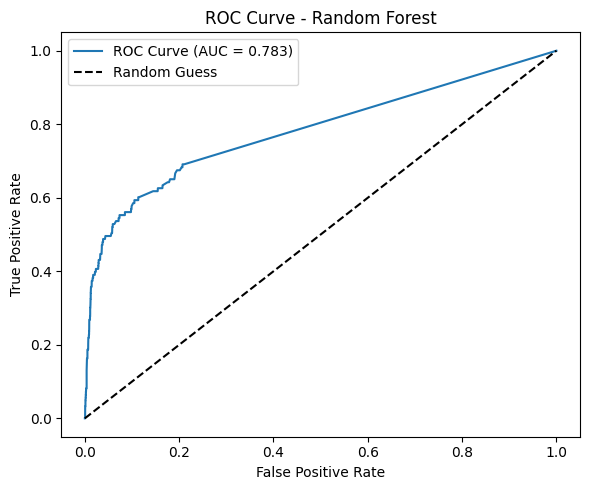

In [15]:
# Plot the ROC Curve
plt.figure(figsize = (6, 5))
plt.plot(fpr, tpr, label = f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.tight_layout()
plt.show()

### 2.3 GridSearchCV to find the best combination of hyperparameters for Random Forest Model 

Rationale for GridSearchCV:
- We want to improve model performance (measured by ROC-AUC) by testing different parameter settings (n_estimators, max_depth, min_samples_split) systematically.

Key Random Forest hyperparameters:
- `n_estimators`: Number of trees in the Random Forest. Having more trees can improve model performance but increase training time. 
- `max_depth`: Maximum depth of each tree which controls the model complexity
- `min_samples_split`: Minimum samples required to split a node. Larger `min_samples_split` prevents overfitting as it requires more samples to create a split.

#### How the GridSearchCV works?

GridSearchCV tries every combination in the grid, using cross-validation (CV) to evaluate each combination. We chose cv = 3 (3-fold CV splits), splits the data into 3 parts. The model is trained 3 rounds, each round, the model is trained on a different 2/3 of the data. This CV ensures the model generalises well.

In [16]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state = 42),
    param_grid,
    cv = 3,
    scoring = 'roc_auc',
    n_jobs = 1,       # <<< Only use 1 job (no parallel, less stress on env)
    verbose = 2
)
grid_rf.fit(X_train_reduced, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   3.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   2.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   2.9s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   3.1s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   2.7s
[CV] END max_depth=None, m

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 5, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 200]}"
,scoring,'roc_auc'
,n_jobs,1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [17]:
print("Best Random Forest params:", grid_rf.best_params_)
print("Best cross-validated AUC:", grid_rf.best_score_)

Best Random Forest params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validated AUC: 0.7706305659439936


The performance of the optimal hyperparameter combination identified by GridSearchCV was evaluated using the ROC-AUC metric.

ROC-AUC measures how well the Random Forest model separates the 2 classes (defaulters vs. non-defaulters)

Rationale for using ROC-AUC:
- We have identified the dataset to be imbalanced, so using accuracy metric can be misleading. A model that always predicts the majority class could still appear "accurate", even though it performs poorly on the minority class. Thus, the model might fail to identify important minority cases, like defaulters, which could cause harm to the bank.
- In contrast, ROC-AUC looks at how well the model separates defaulters vs. non-defaulters, so it is much more reliable compared to accuracy metric.

In [ ]:
# Evaluate the Best Model on Test Set
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Predict probabilities (for AUC) and classes
y_proba = grid_rf.best_estimator_.predict_proba(X_test_reduced)[:, 1]
y_pred = grid_rf.best_estimator_.predict(X_test_reduced)

# Evaluate
print("Test set ROC AUC:", roc_auc_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Test set ROC AUC: 0.7924646201406917
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      7169
           1       0.37      0.11      0.17       123

    accuracy                           0.98      7292
   macro avg       0.68      0.56      0.58      7292
weighted avg       0.97      0.98      0.98      7292

Confusion Matrix:
 [[7145   24]
 [ 109   14]]


Based on the Classification Report, even though the ROC-AUC shows a high value of 0.80, the recall value is low, and false negative rate is very high (0.88). In the financial institution context, type II error which is the false negative rate might be a greater consequence. The model would approve a credit card for someone who is actually a bad customer (likely to default) the bank loses money if the applicant with a poor credit history gets approved, and later fails to pay. Hence, to improve on this, section 3 contains different enhancements made to the baseline model to improve the performance metrics.

## 3. Random Forest Model Enhancements / Variants

### 3.1 Random Forest Model with SMOTE and Fixed Hyperparameters

In [23]:

# Initialise Random Forest 
rf_model_smote = RandomForestClassifier(
    n_estimators = 100,        # no. of trees
    max_depth = 10,           
    min_samples_split = 20,   
    min_samples_leaf = 10,
    max_features = 'sqrt',     # random feature selection, diff trees see different subset of features 
    bootstrap = True,          # bagging, ensemble learning
    random_state = 42,
    n_jobs = -1               # for parallel processing
)

rf_model_smote.fit(X_balance, y_balance)

#  predictions
y_pred_smote = rf_model_smote.predict(X_test)
y_pred_proba_smote = rf_model_smote.predict_proba(X_test)[:, 1]

# performance metrics 
precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba_smote)
pr_auc = auc(recall, precision)


print(f"Accuracy: {accuracy_score(y_test, y_pred_smote):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_smote):.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote))

# confusion Matrix
cm = confusion_matrix(y_test, y_pred_smote)
print("Confusion Matrix:")
print(cm)

print(f"\nRates:")
total_0 = cm[0,0] + cm[0,1]  
total_1 = cm[1,0] + cm[1,1] 


print(f"\nSpecificity (True Negative Rate): {cm[0,0]/total_0:.4f}")
print(f"False Positive Rate: {cm[0,1]/total_0:.4f}")
print(f"Sensitivity (Recall/True Positive Rate): {cm[1,1]/total_1:.4f}")
print(f"False Negative Rate: {cm[1,0]/total_1:.4f}")



Accuracy: 0.8996
ROC AUC: 0.6044
PR AUC: 0.0430

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      7169
           1       0.04      0.20      0.06       123

    accuracy                           0.90      7292
   macro avg       0.51      0.56      0.51      7292
weighted avg       0.97      0.90      0.93      7292

Confusion Matrix:
[[6535  634]
 [  98   25]]

Rates:

Specificity (True Negative Rate): 0.9116
False Positive Rate: 0.0884
Sensitivity (Recall/True Positive Rate): 0.2033
False Negative Rate: 0.7967


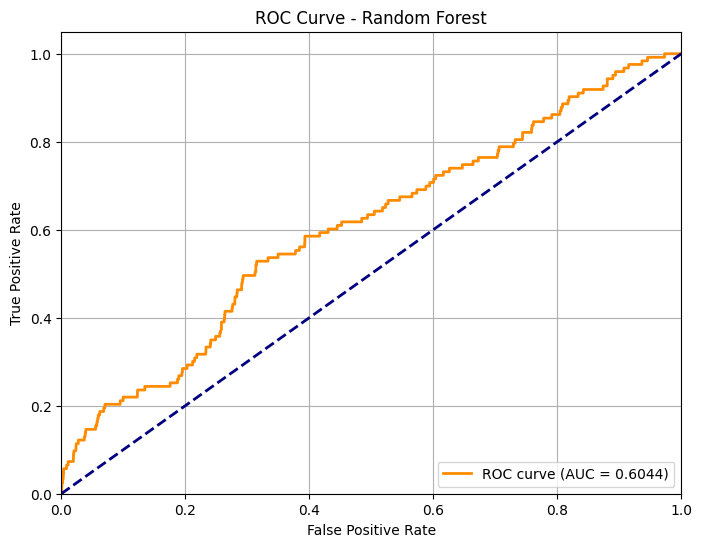

In [24]:
# Plot ROC curve 
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_smote)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba_rf):.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Issues with random forest model using training set balanced using smote:

1. AUC of 0.6 is only slightly better than random guesssing, contradicts the 0.90 accuracy rate. The accuracy rate might be misleading because majority class dominates (`label` = 0 for non default). The model might not be discriminating well between the 2 classes. 

2. Although recall increased from the baseline model (0.20 from 0.11), the trade off is lower precision and f1 score as these are nearly 0 for `label` = 1. Since the minority class is extremely small (about 0.02%), SMOTE might produce unrealisitc synthetic minority points, and the model might be overfitting to the SMOTE-generated data by learning the artificial patterns created by SMOTE but not generalizing well to the test set. Some features are dominated by 0s or categorical dummies.

3. Potential changes made to this model: 
 - to lower the threshold to 0.3 from 0.5 to capture more defaulters (true positives) (refer to section 3.2)
 - to change to class_weight="balanced" to replace SMOTE (refer to section 3.4)
 - change the model with features that are engineered (refer to section 3.4)

### 3.2 Random Forest Model (adjusted threshold)

In [26]:
rf_model_thres = RandomForestClassifier(
    n_estimators=100,        # no. of trees
    max_depth=10,           
    min_samples_split=20,   
    min_samples_leaf=10,
    max_features='sqrt',     # random feature selection, diff trees see different subset of features 
    bootstrap=True,          # bagging, ensemble learning
    random_state=42,
    n_jobs=-1               # for parallel processing
)

rf_model_thres.fit(X_balance, y_balance)

y_pred_thres = rf_model_thres.predict(X_test)
y_pred_proba_thres = rf_model_thres.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred_adj = (y_pred_proba_thres >= threshold).astype(int)


# performance metrics 
precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba_thres)
pr_auc = auc(recall, precision)


print(f"Accuracy: {accuracy_score(y_test, y_pred_adj):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_thres):.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adj))

# confusion Matrix
cm = confusion_matrix(y_test, y_pred_adj)
print("Confusion Matrix:")
print(cm)

print(f"\nRates:")
total_0 = cm[0,0] + cm[0,1]  
total_1 = cm[1,0] + cm[1,1] 

print(f"\nSpecificity (True Negative Rate): {cm[0,0]/total_0:.4f}")
print(f"False Positive Rate: {cm[0,1]/total_0:.4f}")
print(f"Sensitivity (Recall/True Positive Rate): {cm[1,1]/total_1:.4f}")
print(f"False Negative Rate: {cm[1,0]/total_1:.4f}")


Accuracy: 0.5499
ROC AUC: 0.6044
PR AUC: 0.0430

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.55      0.71      7169
           1       0.02      0.61      0.04       123

    accuracy                           0.55      7292
   macro avg       0.51      0.58      0.37      7292
weighted avg       0.97      0.55      0.69      7292

Confusion Matrix:
[[3935 3234]
 [  48   75]]

Rates:

Specificity (True Negative Rate): 0.5489
False Positive Rate: 0.4511
Sensitivity (Recall/True Positive Rate): 0.6098
False Negative Rate: 0.3902


Recall for `label` = 1 increase significantly (0.6) but at the cost of much lower precision, F1-score and accuracy. Most non-defaulters are now wrongly flagged as defaulters. Adjusting threshold does not quite solve the issue since the model cannot tell defaulters apart confidently. Even at threshold 0.3, only a small group of samples truly correspond to real defaulters.

### 3.3 Random Forest Model with Class-Weight Balancing Instead of SMOTE) 


To address the severe class imbalance in the dataset, we trained a Random Forest with class_weight='balanced'. This approach automatically assigns higher importance to the minority class (defaulters) during training, without generating synthetic samples as in SMOTE.

In [9]:

rf_model_cw = RandomForestClassifier(
    n_estimators = 200,
    max_depth = 15,
    min_samples_leaf = 5,
    min_samples_split = 10,
    max_features = 'sqrt',
    class_weight = 'balanced',
    random_state = 42,
    n_jobs = -1
)

rf_model_cw.fit(X_train, y_train)


y_pred_cw = rf_model_cw.predict(X_test)
y_pred_proba_cw = rf_model_cw.predict_proba(X_test)[:, 1] 

cv_scores_rf = cross_val_score(rf_model_cw, X_train, y_train, cv = 5, scoring = 'roc_auc')
print(f"Cross-Validation AUC: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")

precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba_cw)
pr_auc = auc(recall, precision)


print(f"Accuracy: {accuracy_score(y_test, y_pred_cw):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_cw):.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print("\n Classification Report")
print(classification_report(y_test, y_pred_cw))


print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_cw)
print(cm)

print(f"\nRates:")

total_0 = cm[0,0] + cm[0,1]  
total_1 = cm[1,0] + cm[1,1] 

print(f"\nSpecificity (True Negative Rate): {cm[0,0]/total_0:.4f}")
print(f"False Positive Rate: {cm[0,1]/total_0:.4f}")
print(f"Sensitivity (Recall/True Positive Rate): {cm[1,1]/total_1:.4f}")
print(f"False Negative Rate: {cm[1,0]/total_1:.4f}")



Cross-Validation AUC: 0.7302 (+/- 0.0294)
Accuracy: 0.9604
ROC AUC: 0.6905
PR AUC: 0.1080

 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7169
           1       0.15      0.30      0.20       123

    accuracy                           0.96      7292
   macro avg       0.57      0.64      0.59      7292
weighted avg       0.97      0.96      0.97      7292

Confusion Matrix:
[[6966  203]
 [  86   37]]

Rates:

Specificity (True Negative Rate): 0.9717
False Positive Rate: 0.0283
Sensitivity (Recall/True Positive Rate): 0.3008
False Negative Rate: 0.6992


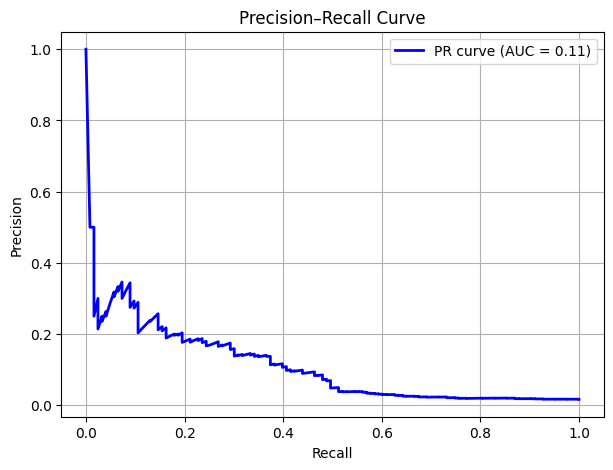

In [29]:
# Precision recall curve
plt.figure(figsize=(7,5))
plt.plot(recall, precision, color='b', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

Most of the performance metric values improved quite a bit from the model that uses smote especially recall, false negative rate, pr auc which are most important as having high false negative rate can be quite costly if a defaulter is wrongly predicted as non-defaulter. Even though PR AUC improved slightly, but the model may be doing slightly better than random guessing only because the features might not provide enough information to distinguish between defaulters and non-defaulters. The model still struggles to detect the minority class effectively. Feature engineering will be done under the section 2.4

### 3.4 Random Forest Model  With Feature Engineering

####   3.4.1 Check feature importance

In [21]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': rf_model_cw.feature_importances_
}).sort_values('importance', ascending = False)

print(feature_importance.head(10))


                     feature  importance
11            years_employed    0.163267
9                        age    0.151398
12            amt_income_log    0.144031
8            cnt_fam_members    0.042842
3               cnt_children    0.032215
2            flag_own_realty    0.031911
1               flag_own_car    0.027611
6                 flag_phone    0.027553
16  name_income_type_Working    0.025975
0                code_gender    0.023057


Based on the feature importance for the top 10 features, only the top 3 features seem to have predictive power as all other features have importance of less than 0.01. 

#### 3.4.2 Feature Engineering

In [24]:

import warnings
warnings.filterwarnings('ignore')

def new_features(X):
   
    X_eng = X.copy()
    
    # use ratio
    if 'years_employed' in X.columns and 'age' in X.columns:
        X_eng['career_ratio'] = X['years_employed'] / (X['age'] + 1)
        X_eng['employment_stability'] = X['years_employed'] / (X['age'] - 18 + 1)  # Years since adult
    
    if 'amt_income_log' in X.columns and 'cnt_fam_members' in X.columns:
        X_eng['income_per_member'] = X['amt_income_log'] / (X['cnt_fam_members'] + 1)
        X_eng['log_income_per_member'] = np.log1p(X_eng['income_per_member'])
    
    # interaction terms
    if 'age' in X.columns and 'amt_income_log' in X.columns:
        X_eng['age_income_interaction'] = X['age'] * X['amt_income_log']
        X_eng['age_income_ratio'] = X['age'] / (X['amt_income_log'] + 1)
    
    # nonlinear transf
    if 'age' in X.columns:
        X_eng['age_squared'] = X['age'] ** 2
        X_eng['age_cubed'] = X['age'] ** 3
        X_eng['log_age'] = np.log1p(X['age'])
    
    if 'years_employed' in X.columns:
        X_eng['employment_squared'] = X['years_employed'] ** 2
        X_eng['log_employment'] = np.log1p(X['years_employed'] + 1)
    

    return X_eng

# apply the feature engineering defined above
X_engineered = new_features(X_encoded)

# use one-hot encoding for cat variables
categorical_eng_cols = X_engineered.select_dtypes(include=['object', 'category']).columns
if len(categorical_eng_cols) > 0:
    X_engineered = pd.get_dummies(X_engineered, columns=categorical_eng_cols, drop_first=True)

X_train_eng, X_test_eng, y_train, y_test = train_test_split(
    X_engineered, y, test_size=0.2, random_state=42, stratify=y
)

#  feature selection using correlation with target
correlations = X_train_eng.corrwith(y_train).abs().sort_values(ascending=False)

# select top correlated features
selected_features = correlations[correlations > 0.01].index.tolist()
if len(selected_features) < 20: 
    selected_features = correlations.head(30).index.tolist()

print(f"Selected {len(selected_features)} features for modeling")

X_train_selected = X_train_eng[selected_features]
X_test_selected = X_test_eng[selected_features]



Selected 30 features for modeling


#### 3.4.3 Modelling

In [25]:
rf_engineered = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_leaf=5,
    min_samples_split=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_engineered.fit(X_train_selected, y_train)


cv_scores = cross_val_score(rf_engineered, X_train_selected, y_train, 
                           cv=5, scoring='roc_auc', n_jobs=-1)
print(f"Cross-Validation AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

y_pred_eng = rf_engineered.predict(X_test_selected)
y_pred_proba_eng = rf_engineered.predict_proba(X_test_selected)[:, 1]



Cross-Validation AUC: 0.7390 (+/- 0.0103)


#### 3.4.4 Evaluation of Performance Metrics

In [ ]:
def evaluation(model_name, y_test, y_pred_eng, y_pred_proba_eng, feature_names, model):
    print(f"\n{model_name} Evaluation")


    roc_auc_value = roc_auc_score(y_test, y_pred_proba_eng)
    acc = accuracy_score(y_test, y_pred_eng)
    prec = precision_score(y_test, y_pred_eng)
    rec = recall_score(y_test, y_pred_eng)
    f1 = f1_score(y_test, y_pred_eng)
    pr_precision, pr_recall, _ = precision_recall_curve(y_test, y_pred_proba_eng)
    pr_auc_value = auc(pr_recall, pr_precision)


    print(f"ROC AUC: {roc_auc_value:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"PR AUC:  {pr_auc_value:.4f}") 
    
    # Confusion Matrix
    print(f"\nConfusion Matrix")
    cm = confusion_matrix(y_test, y_pred_eng)
    print(cm)

    print("\n Classification Report")
    print(classification_report(y_test, y_pred_eng))
   
    total_0 = cm[0,0] + cm[0,1]
    total_1 = cm[1,0] + cm[1,1]

    print(f"\nRates:")

    print(f"\nSpecificity (True Negative Rate): {cm[0,0]/total_0:.4f}")
    print(f"False Positive Rate: {cm[0,1]/total_0:.4f}")
    print(f"Sensitivity (Recall/True Positive Rate): {cm[1,1]/total_1:.4f}")
    print(f"False Negative Rate: {cm[1,0]/total_1:.4f}")

    # for plotting in part 2.4.5
    return {
        'roc_auc': roc_auc_value,
        'pr_auc': pr_auc_value,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'confusion_matrix': cm
    }
#1.  evaluate engineered model
results_eng = evaluation(
    "Random Forest with Feature Engineering", 
    y_test, y_pred_eng, y_pred_proba_eng, 
    selected_features, rf_engineered
)


# 2.  train "baseline" model (using class weight (rf_model_cw), no feature engineering)

results_cw = evaluation(
    "Random Forest (No Engineering)", 
    y_test, y_pred_cw, y_pred_proba_cw, 
    X_train.columns, rf_model_cw
)


Random Forest with Feature Engineering Evaluation
ROC AUC: 0.7172
Accuracy: 0.9616
PR AUC:  0.1227

Confusion Matrix
[[6964  205]
 [  75   48]]

 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7169
           1       0.19      0.39      0.26       123

    accuracy                           0.96      7292
   macro avg       0.59      0.68      0.62      7292
weighted avg       0.98      0.96      0.97      7292


Rates:

Specificity (True Negative Rate): 0.9714
False Positive Rate: 0.0286
Sensitivity (Recall/True Positive Rate): 0.3902
False Negative Rate: 0.6098

Random Forest Baseline (No Engineering) Evaluation
ROC AUC: 0.6905
Accuracy: 0.9604
PR AUC:  0.1080

Confusion Matrix
[[6966  203]
 [  86   37]]

 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7169
           1       0.15      0.30      0.20       123

    accuracy    

For the random forest model with feature engineered features, most of the performance metrics improved quite a bit as compared to the baseline model of random forest using class-weighting. 
1. The model is moderately strong. It performs significantly better than random guessing and slightly better than the baseline
2. After feature engineering, the model identifies more true positives with slightly better confidence, however, more needs to be done to reduce the false negative rate which can be very costly error. 

#### 3.4.5 Visualisation

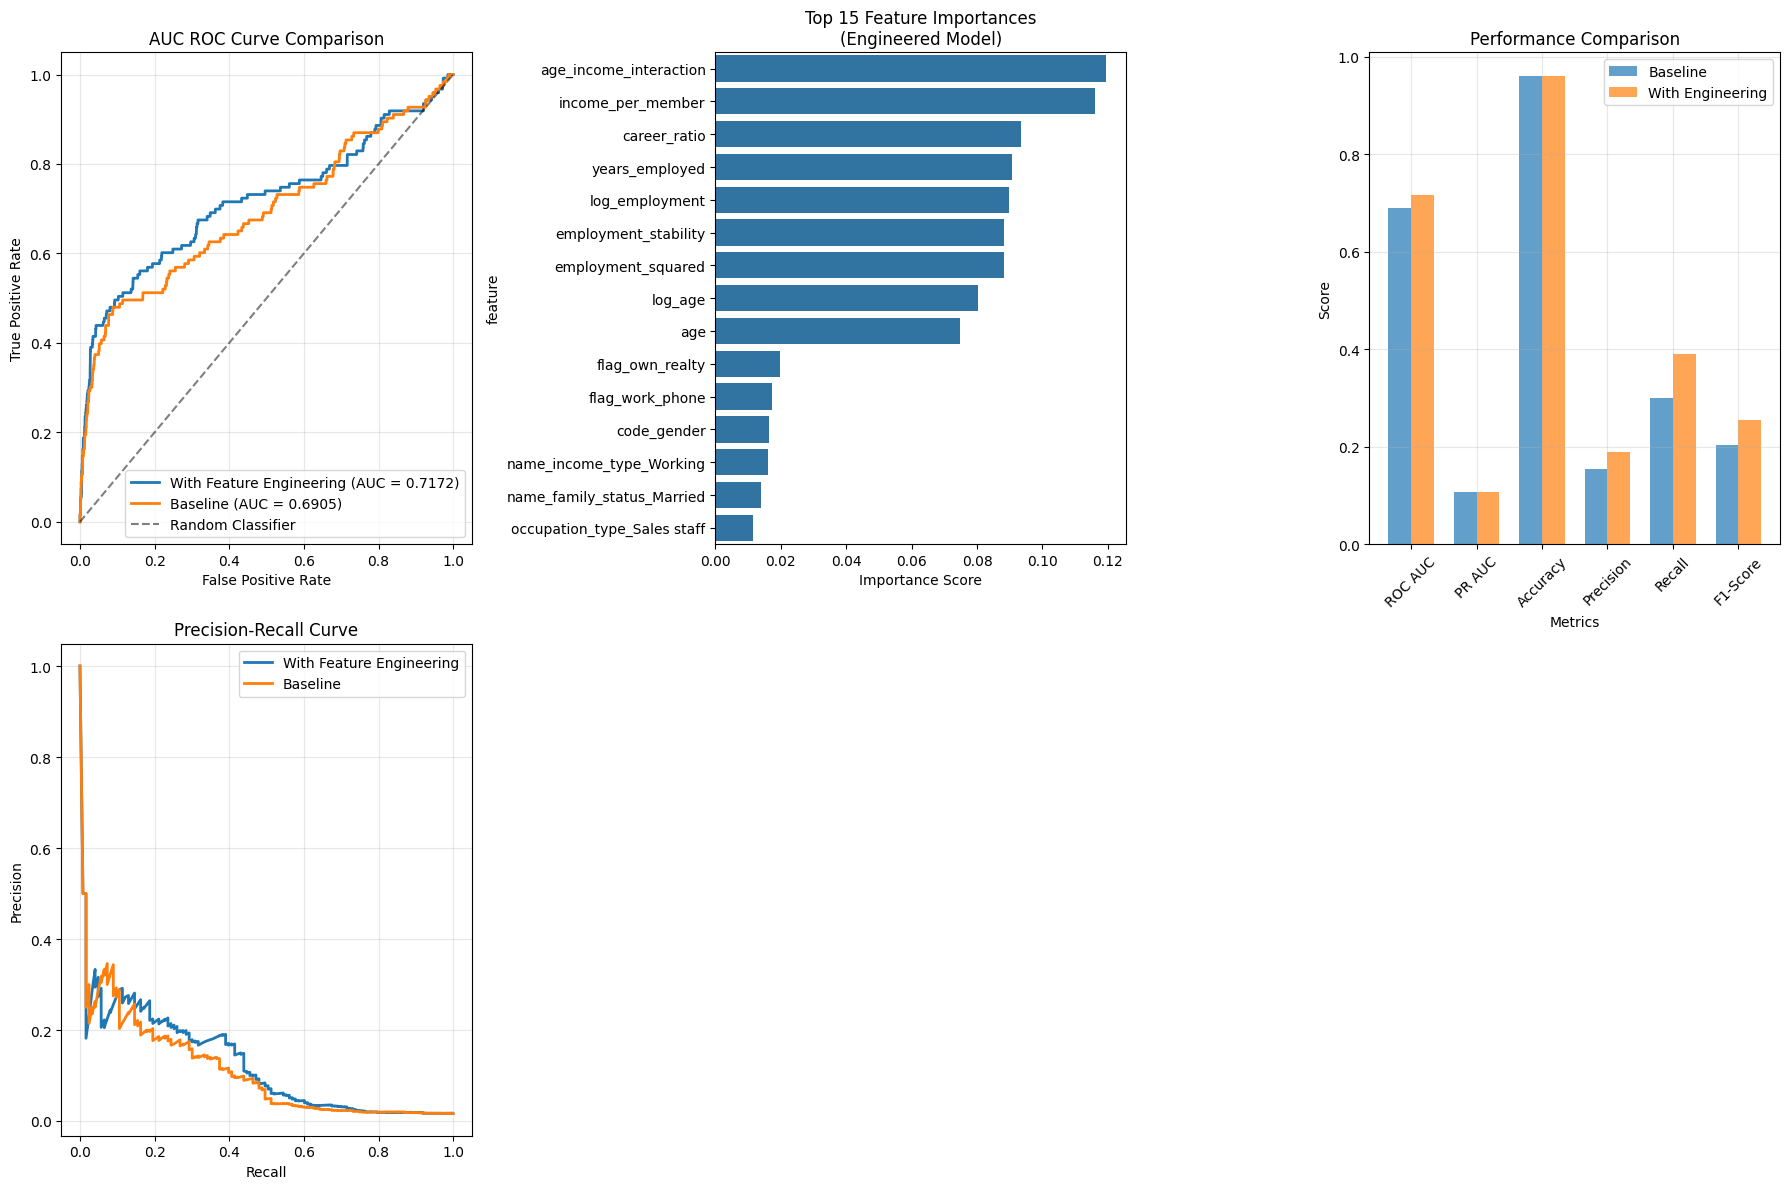

In [28]:

plt.figure(figsize=(18, 12))

# auc roc curve comparison plot
plt.subplot(2, 3, 1)
fpr_eng, tpr_eng, _ = roc_curve(y_test, y_pred_proba_eng)
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_proba_cw)

plt.plot(fpr_eng, tpr_eng, label=f'With Feature Engineering (AUC = {results_eng["roc_auc"]:.4f})', linewidth=2)
plt.plot(fpr_base, tpr_base, label=f'Baseline (AUC = {results_cw["roc_auc"]:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC ROC Curve Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

#  feature importance plot (show new features)
plt.subplot(2, 3, 2)
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_engineered.feature_importances_
}).sort_values('importance', ascending=False).head(15)

sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Top 15 Feature Importances\n(Engineered Model)')
plt.xlabel('Importance Score')

# performance metrics comparison plot
plt.subplot(2, 3, 3)
metrics = ['ROC AUC', 'PR AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
base_values = [results_cw['roc_auc'], results_cw['pr_auc'],results_cw['accuracy'], results_cw['precision'], 
               results_cw['recall'], results_cw['f1']]
eng_values = [results_eng['roc_auc'], results_cw['pr_auc'], results_eng['accuracy'], results_eng['precision'], 
              results_eng['recall'], results_eng['f1']]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, base_values, width, label='Baseline', alpha=0.7)
plt.bar(x + width/2, eng_values, width, label='With Engineering', alpha=0.7)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Comparison')
plt.xticks(x, metrics, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# precision recall curve plot
plt.subplot(2, 3, 4)
precision_eng, recall_eng, _ = precision_recall_curve(y_test, y_pred_proba_eng)
precision_base, recall_base, _ = precision_recall_curve(y_test, y_pred_proba_cw)

plt.plot(recall_eng, precision_eng, label='With Feature Engineering', linewidth=2)
plt.plot(recall_base, precision_base, label='Baseline', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. XGBOOST Model

#### 3.1 XGBoost Model (version 1)

Rationale of XGBoost with `scale_pos_weight1` & regularisation:
- Class imbalance handling using `scale_pos_weight = (# negatives / # positives)` which penalises mistakes on minority class more (defaulters). This would improve recall on the minority (defaulters).
- Regularisation using `reg_alpha = 0.1` and `reg_lambda = 0.1` to reduce overfitting 

We chose log loss as the evaluation metric, because it trains XGBoost to penalise the model for being confidently wrong (in this case wrongly predicting defaulters as non-defaulters). 

Cross-Validation AUC: 0.7575 (+/- 0.0266)

--- RANDOM FOREST WITH CLASS WEIGHT EVALUATION ---
AUC: 0.6905
Accuracy: 0.9604
Precision: 0.1542
Recall: 0.3008
F1-Score: 0.2039

Confusion Matrix:
[[6966  203]
 [  86   37]]
TN: 6966, FP: 203, FN: 86, TP: 37
Specificity: 0.9717
False Positive Rate: 0.0283
Sensitivity (Recall): 0.3008
False Negative Rate: 0.6992

--- XGBOOST EVALUATION ---
AUC: 0.7182
Accuracy: 0.9586
Precision: 0.1903
Recall: 0.4472
F1-Score: 0.2670

Confusion Matrix:
[[6935  234]
 [  68   55]]
TN: 6935, FP: 234, FN: 68, TP: 55
Specificity: 0.9674
False Positive Rate: 0.0326
Sensitivity (Recall): 0.4472
False Negative Rate: 0.5528

MODEL COMPARISON SUMMARY
                             model     auc  accuracy  precision  recall  \
0  Random Forest With Class Weight  0.6905    0.9604     0.1542  0.3008   
1                          XGBoost  0.7182    0.9586     0.1903  0.4472   

       f1  
0  0.2039  
1  0.2670  


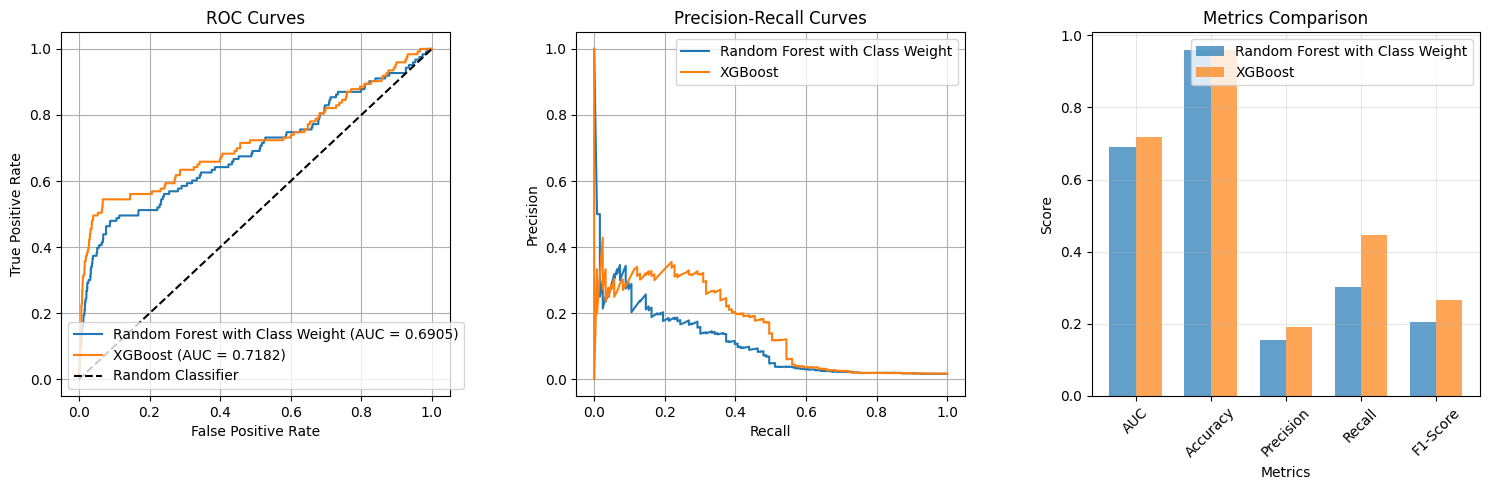

In [29]:

## XGBoost (with Scale Pos Weight) and with regularisation

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=15,   
    learning_rate=0.1,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    eval_metric='logloss'
)

# Train
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Cross-validation
cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std() * 2:.4f})")

## COMPREHENSIVE EVALUATION FUNCTION
def evaluate_model(model_name, y_true, y_pred, y_pred_proba):
    print(f"\n--- {model_name.upper()} EVALUATION ---")
    
    # Basic metrics
    auc = roc_auc_score(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"AUC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    print(f"TN: {cm[0,0]}, FP: {cm[0,1]}, FN: {cm[1,0]}, TP: {cm[1,1]}")
    
    # Rates
    total_0 = cm[0,0] + cm[0,1]
    total_1 = cm[1,0] + cm[1,1]
    print(f"Specificity: {cm[0,0]/total_0:.4f}")
    print(f"False Positive Rate: {cm[0,1]/total_0:.4f}")
    print(f"Sensitivity (Recall): {cm[1,1]/total_1:.4f}")
    print(f"False Negative Rate: {cm[1,0]/total_1:.4f}")
    
    return {
        'model': model_name,
        'auc': auc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

# Evaluate both models
results = []
results.append(evaluate_model("Random Forest With Class Weight", y_test, y_pred_cw, y_pred_proba_cw))
results.append(evaluate_model("XGBoost", y_test, y_pred_xgb, y_pred_proba_xgb))

## COMPARISON SUMMARY

print("\nMODEL COMPARISON SUMMARY")

comparison_df = pd.DataFrame(results)
print(comparison_df[['model', 'auc', 'accuracy', 'precision', 'recall', 'f1']].round(4))



#---------------------------------------


plt.figure(figsize=(15, 5))

# ROC Curve
plt.subplot(1, 3, 1)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_cw)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest with Class Weight (AUC = {roc_auc_score(y_test, y_pred_proba_cw):.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_pred_proba_xgb):.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)

# Precision-Recall Curves
plt.subplot(1, 3, 2)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_cw)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)

plt.plot(recall_rf, precision_rf, label='Random Forest with Class Weight')
plt.plot(recall_xgb, precision_xgb, label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)

#  Metrics Comparison
plt.subplot(1, 3, 3)
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
rf_metrics = [results[0]['auc'], results[0]['accuracy'], results[0]['precision'], 
              results[0]['recall'], results[0]['f1']]
xgb_metrics = [results[1]['auc'], results[1]['accuracy'], results[1]['precision'], 
               results[1]['recall'], results[1]['f1']]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, rf_metrics, width, label='Random Forest with Class Weight', alpha=0.7)
plt.bar(x + width/2, xgb_metrics, width, label='XGBoost', alpha=0.7)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Metrics Comparison')
plt.xticks(x, metrics, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


#### 3.2 XGBoost Model (version 2)

#### Baseline model with default parameters for tuning later

Firstly, we trained a baseline XGBoost model to establish a reference performance. Then, we used GridSearchCV to tune the model's parameters and identify the best settings using ROC-AUC as the optimisation metric. Finally, we compared both models on the test set using various evaluation metrics: accuracy, ROC-AUC, precision, recall, and confusion matrix.

We chose log loss as the evaluation metric, because it trains XGBoost to penalise the model for being confidently wrong (in this case wrongly predicting defaulters as non-defaulters). 

In [30]:
xgb_clf = xgb.XGBClassifier(
    n_estimators = 100,
    max_depth = 5,
    learning_rate = 0.1,
    use_label_encoder = False,   # avoid deprecation warning
    eval_metric = 'logloss',     # set for classification
    random_state = 42
)

# Fit on training data
xgb_clf.fit(X_train_reduced, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


#### Evaluating this baseline XGBoost model (before tuning)

In [31]:
# Get predicted probabilities for ROC AUC
y_proba = xgb_clf.predict_proba(X_test_reduced)[:, 1]
y_pred = xgb_clf.predict(X_test_reduced)

print("Test ROC AUC:", roc_auc_score(y_test, y_proba))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Test ROC AUC: 0.6628176645833971
Test Accuracy: 0.9829950630828305
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      7169
           1       0.00      0.00      0.00       123

    accuracy                           0.98      7292
   macro avg       0.49      0.50      0.50      7292
weighted avg       0.97      0.98      0.97      7292



In [32]:
# Get predicted probabilities for ROC AUC
y_proba = xgb_clf.predict_proba(X_test_reduced)[:, 1]
y_pred = xgb_clf.predict(X_test_reduced)

print("Test ROC AUC:", roc_auc_score(y_test, y_proba))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Test ROC AUC: 0.6628176645833971
Test Accuracy: 0.9829950630828305
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      7169
           1       0.00      0.00      0.00       123

    accuracy                           0.98      7292
   macro avg       0.49      0.50      0.50      7292
weighted avg       0.97      0.98      0.97      7292



#### GridSearchCV for hyperparameter tuning of XGBoost model

In [33]:

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_base = xgb.XGBClassifier(
    use_label_encoder = False, 
    eval_metric = 'logloss',
    random_state = 42
)

grid_xgb = GridSearchCV(
    estimator = xgb_base,
    param_grid = param_grid,
    scoring = 'roc_auc',
    cv = 3,
    n_jobs = 1,           # to avoid subprocess errors
    verbose = 2
)

grid_xgb.fit(X_train_reduced, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200], 'subsample': [0.8, 1.0]}"
,scoring,'roc_auc'
,n_jobs,1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [34]:
print("Best params:", grid_xgb.best_params_)
print("Best cross-validated AUC:", grid_xgb.best_score_)

Best params: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validated AUC: 0.7551214046453438


In [35]:
best_xgb = grid_xgb.best_estimator_

# Predict on test data
y_pred_xgb2 = best_xgb.predict(X_test_reduced)
y_proba_xgb2 = best_xgb.predict_proba(X_test_reduced)[:, 1]

print("Test ROC AUC:", roc_auc_score(y_test, y_proba_xgb2 ))
print("Test Accuracy:", accuracy_score(y_test, y_pred_xgb2))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb2))

Test ROC AUC: 0.7166277116809389
Test Accuracy: 0.9814865606143719
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      7169
           1       0.36      0.12      0.18       123

    accuracy                           0.98      7292
   macro avg       0.67      0.56      0.59      7292
weighted avg       0.97      0.98      0.98      7292

Confusion Matrix:
 [[7142   27]
 [ 108   15]]


#### Evaluate the tuned XGBoost model

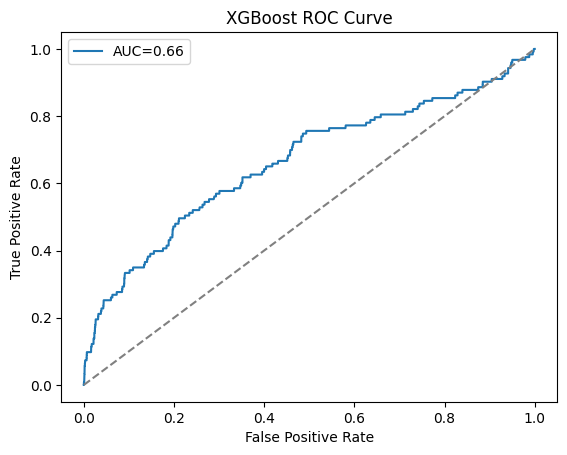

In [36]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label = f"AUC={roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend()
plt.show()